# MLOps stage 1 : Data Management and Exploration

## Overview

This tutorial demonstrates how to use Vertex AI for E2E MLOps on Google Cloud in production

## Objective

In this tutorial, you learn how to use BigQuery as a dataset for training with Vertex AI.

This tutorial uses the following Google Cloud ML services:
- Vertex AI Datasets
- BigQuery Datasets

The steps performed include:
- Create a BigQuery dataset from CSV files.
- Create a Vertex AI Dataset resource from BigQuery table
- Select rows from a BigQuery dataset into a pandas dataframe -- compatible for custom training.

## Dataset

The dataset used in this example is the [Synthetic Financial Fraud dataset from Kaggle](https://www.kaggle.com/datasets/ealaxi/paysim1). PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

### Installations

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

ONCE_ONLY = False
if ONCE_ONLY:
    ! pip3 install -U {USER_FLAG} -q tensorflow==2.5 \
                                     tensorflow-data-validation==1.2 \
                                     tensorflow-transform==1.2 \
                                     tensorflow-io==0.18 
    
    ! pip3 install --upgrade {USER_FLAG} -q google-cloud-aiplatform[tensorboard] \
                                            google-cloud-pipeline-components \
                                            google-cloud-bigquery \
                                            google-cloud-logging \
                                            apache-beam[gcp] \
                                            pyarrow \
                                            cloudml-hypertune

In [4]:
# Restart the kernel
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Import Libraries and Define Constants

In [ ]:
import google.cloud.aiplatform as aip
import tensorflow as tf
import tensorflow_data_validation as tfdv
import pandas as pd
from google.cloud import bigquery

In [3]:
REGION='us-central1'
PROJECT_ID='bq-experiments-350102'

In [4]:
BUCKET_NAME = "bq-experiments-fraud"
BUCKET_URI = f"gs://{BUCKET_NAME}"

## Initialize Vertex AI SDK for Python

In [5]:
aip.init(project=PROJECT_ID, location=REGION)

## Data Dictionary

**step**: **int**: 1-743:  Maps a unit of time in the real world. In this case 1 step is 1 hour of time. <br>
**type**: **enum**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER <br>
**amount**: **decimal**: 0-92.4m: amount of the transaction in local currency. <br>
**nameOrig**: **string**: 6353307 unique values: customer who started the transaction. <br>
**oldBalanceOrg**: **decimal**: 0-59.6m: initial balance before the transaction. <br>
**newBalanceOrig**: **decimal**: 0-49.6m: customer's balance after the transaction. <br>
**nameDest**: **string**: 2722326 unique values: recipient ID of the transaction. <br>
**oldBalanceDest**: **decimal**: 0-356m: initial recipient balance before the transaction. <br>
**newBalanceDest**: **decimal**: 0-356m: recipient's balance after the transaction. <br>
**isFraud**: **boolean**: 0-1: identifies a fraudulent transaction (1) and non fraudulent (0)<br>

## Create BigQuery Client

In [6]:
bqclient = bigquery.Client(project=PROJECT_ID)

## Create Dataset

In [7]:
IMPORT_FILE = "bq://bq-experiments-350102.synthetic_financial_fraud.fraud_data"
BQ_TABLE = "bq-experiments-350102.synthetic_financial_fraud.fraud_data"

In [7]:
# Send the dataset to the API for creation, with an explicit timeout.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
dataset_id = "bq-experiments-350102.synthetic_financial_fraud"
dataset = bigquery.Dataset(dataset_id)
dataset.location = "US"
dataset = bqclient.create_dataset(dataset, timeout=30)  # Make an API request.
print("Created dataset {}.{}".format(bqclient.project, dataset.dataset_id))

Created dataset bq-experiments-350102.synthetic_financial_fraud


## Create BiqQuery Load Job

In [8]:
table_id = BQ_TABLE

job_config = bigquery.LoadJobConfig(
    autodetect=False,
    schema=[
        bigquery.SchemaField("step", "INT64", mode="REQUIRED"),
        bigquery.SchemaField("type", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("amount", "FLOAT64", mode="REQUIRED"),
        bigquery.SchemaField("nameOrig", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("oldBalanceOrg", "FLOAT64", mode="REQUIRED"),
        bigquery.SchemaField("newBalanceOrig", "FLOAT64", mode="REQUIRED"),
        bigquery.SchemaField("nameDest", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("oldBalanceDest", "FLOAT64", mode="REQUIRED"),
        bigquery.SchemaField("newBalanceDest", "FLOAT64", mode="REQUIRED"),
        bigquery.SchemaField("isFraud", "BOOL", mode="REQUIRED"),
        bigquery.SchemaField("isFlaggedFraud", "BOOL", mode="REQUIRED"),
    ],
    source_format=bigquery.SourceFormat.CSV,
    write_disposition="WRITE_TRUNCATE",
    skip_leading_rows=1
)
uri = "gs://bq-experiments-fraud/synthetic-fraud.csv"

load_job = bqclient.load_table_from_uri(
    uri, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Wait for the job to complete.

table = bqclient.get_table(table_id)
print("Loaded {} rows to table {}".format(table.num_rows, table_id))

Loaded 6362620 rows to table bq-experiments-350102.synthetic_financial_fraud.fraud_data


In [9]:
query = """
    SELECT step,
        type, 
        amount,
        nameOrig,
        oldBalanceOrg,
        newBalanceOrig,
        nameDest,
        oldBalanceDest,
        newBalanceDest,
        isFraud,
        isFlaggedFraud
    FROM `bq-experiments-350102.synthetic_financial_fraud.fraud_data`
"""

_ = bqclient.query(query)
rows = _.result()
dataframe = rows.to_dataframe()
dataframe.head(10)

,step,type,amount,nameOrig,oldBalanceOrg,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,255,DEBIT,3188.16,C389755673,29321.00,26132.84,C944464188,123342.90,126531.06,False,False
1,258,DEBIT,2488.01,C1943465811,20206.00,17717.99,C1935607545,5638603.71,5641091.72,False,False
2,1,DEBIT,2633.08,C1290614253,124905.00,122271.92,C1992550266,17146.00,0.00,False,False
3,266,DEBIT,1402.09,C2057629098,9990.00,8587.91,C1824011138,646222.73,647624.82,False,False
4,275,DEBIT,4927.73,C1136589927,184306.31,179378.58,C1245026661,1046650.66,1051578.39,False,False
5,21,DEBIT,811.90,C1967993506,16968.00,16156.10,C1585827223,71221.00,47517.08,False,False
6,21,DEBIT,4825.13,C1335966015,11112.00,6286.87,C1692363435,370704.19,375529.33,False,False
7,285,DEBIT,3554.68,C726737289,34695.00,31140.32,C1686875619,11272346.85,11275901.54,False,False
8,299,DEBIT,3183.18,C69438864,0.00,0.00,C1783180469,133928.89,137112.08,False,False
9,311,DEBIT,3944.99,C870531589,46741.00,42796.01,C1474446515,643826.85,647771.84,False,False


# Generate Dataset Statistics with Tensorflow Data Validation

In [12]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=dataframe,
    stats_options=tfdv.StatsOptions(
        label_feature="isFraud", sample_rate=1, num_top_values=50
    ),
)

In [13]:
tfdv.visualize_statistics(stats)

## Explore BigQuery Dataset

<AxesSubplot:ylabel='amount'>

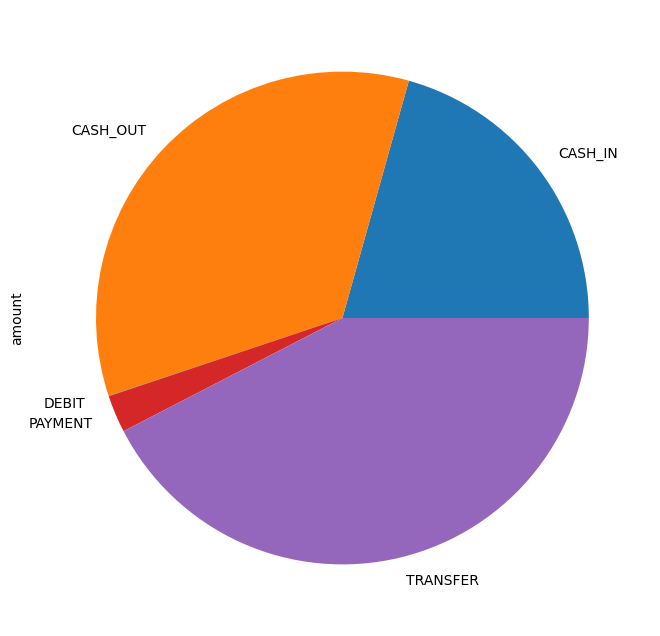

In [8]:
dataframe.groupby('type')['amount'].sum().plot.pie(y='amount', figsize=(8, 8))

In [8]:
print('The types of fraudulent transactions are {}'.format(list(dataframe.loc[dataframe.isFraud == 1].type.drop_duplicates().values)))

The types of fraudulent transactions are ['CASH_OUT', 'TRANSFER']


In [9]:
dfFraudTransfer = dataframe.loc[(dataframe.isFraud == 1) & (dataframe.type == 'TRANSFER')]
print ('The number of fraudulent TRANSFERs = {}'.format(len(dfFraudTransfer)))

The number of fraudulent TRANSFERs = 4097


In [10]:
dfFraudCashout = dataframe.loc[(dataframe.isFraud == 1) & (dataframe.type == 'CASH_OUT')]
print ('The number of fraudulent CASH_OUTs = {}'.format(len(dfFraudCashout)))

The number of fraudulent CASH_OUTs = 4116


In [12]:
print('The type of transactions in which isFlaggedFraud is set: {}'.format(list(dataframe.loc[dataframe.isFlaggedFraud == 1].type.drop_duplicates()))) 

The type of transactions in which isFlaggedFraud is set: ['TRANSFER']


In [14]:
dfFlagged = dataframe.loc[dataframe.isFlaggedFraud == 1]
print('Min amount transacted when isFlaggedFraud is set= {}'.format(dfFlagged.amount.min()))

Min amount transacted when isFlaggedFraud is set= 353874.22


In [16]:
print('Max amount transacted when isFlaggedFraud is set= {}'.format(dfFlagged.amount.max()))

Max amount transacted when isFlaggedFraud is set= 10000000.0


## Create Vertex Managed Dataset

Create the Dataset resource using the create method for the TabularDataset class, which takes the following parameters:
- display_name: The human readable name for the Dataset resource.
- bq_source: Import data items from a BigQuery table into the Dataset resource.
- labels: User defined metadata. In this example, you store the location of the Cloud Storage bucket containing the user defined data.

In [10]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [11]:
dataset = aip.TabularDataset.create(
    display_name="Synthetic Financial Fraud" + "_" + TIMESTAMP,
    bq_source=[IMPORT_FILE],
    labels={"user_metadata": BUCKET_NAME},
)

label_column = "tip_bin"

print(dataset.resource_name)

Creating TabularDataset
Create TabularDataset backing LRO: projects/402374189238/locations/us-central1/datasets/8805577409509195776/operations/885618476863979520
TabularDataset created. Resource name: projects/402374189238/locations/us-central1/datasets/8805577409509195776
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/402374189238/locations/us-central1/datasets/8805577409509195776')
projects/402374189238/locations/us-central1/datasets/8805577409509195776
